In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

In [3]:
df_cases = pd.read_csv('raw_data/covid_cases.csv')
df_deaths = pd.read_csv('raw_data/covid_deaths.csv')
beds = pd.read_csv('raw_data/bed_data.csv')
pop = pd.read_csv('raw_data/covid_county_population.csv')
cvd_dat = pd.read_csv('raw_data/state_covid_data.csv')

# County Population Data

In [ ]:
pop.drop('State', axis=1, inplace=True)

In [ ]:
pop = pop[pop['County Name'] != 'Statewide Unallocated']
df_cases = df_cases[df_cases['County Name'] != 'Statewide Unallocated']
df_deaths = df_deaths[df_deaths['County Name'] != 'Statewide Unallocated']

# Beds dataframe

In [8]:
beds.drop(['State/Local Government', 'Non-Profit', 'For-Profit'], axis=1, inplace=True )

In [9]:
beds['Beds per Person'] = beds.Total / 1000

In [10]:
beds.drop(0, inplace=True)

In [11]:
# dictionary for state names because some data sets use abreviations, some use full state names

states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'}

# Covid-19 Features

In [12]:
# obtain data up until the "target cutoff," which is the last two weeks

cases_small = df_cases.loc[:, :'4/21/20']
deaths_small = df_deaths.loc[:, :'4/21/20']

In [13]:
# couting the number of days since the first case and the first death in each county, this will be used as a feature

cases_small['Days since case1'] = cases_small.astype(bool).sum(axis=1) - 4
deaths_small['Days since death1'] = deaths_small.astype(bool).sum(axis=1) - 4  # don't include first four cols

In [14]:
# in terms of collecting features, we only want these columns right now

cases_small = cases_small[['countyFIPS', 'County Name', 'State', '4/21/20', 'Days since case1']]
deaths_small = deaths_small[['countyFIPS', 'County Name', 'State', '4/21/20', 'Days since death1']]

In [15]:
# renaming the date column

cases_small.columns = ['countyFIPS', 'County Name', 'State', 'Total_cases', 'Days since case1']
deaths_small.columns = ['countyFIPS', 'County Name', 'State', 'Total_deaths', 'Days since death1']

In [16]:
# renaming the states column to merge with the beds dataframe

cases_small.State = cases_small.State.apply(lambda x: states[x])
deaths_small.State = deaths_small.State.apply(lambda x: states[x])

In [17]:
# merging table to include the county beds data

cases_small = cases_small.merge(beds, left_on='State', right_on='Location')
deaths_small = deaths_small.merge(beds, left_on='State', right_on='Location')

In [18]:
# dropping cols we don't need

cases_small.drop(['Location', 'Total'], axis=1, inplace=True)
deaths_small.drop(['Location', 'Total'], axis=1, inplace=True)

In [19]:
# merging the county population data into the dataframe

cases_small = cases_small.merge(pop, left_on='countyFIPS', right_on='countyFIPS')
deaths_small = deaths_small.merge(pop, left_on='countyFIPS', right_on='countyFIPS')

In [20]:
# converting the beds per person column into total beds per county

cases_small['County_beds'] = cases_small['Beds per Person'] * cases_small.population
deaths_small['County_beds'] = deaths_small['Beds per Person'] * deaths_small.population

In [21]:
# converting total beds per county into an integer

cases_small['County_beds'] = cases_small['County_beds'].apply(int)
deaths_small['County_beds'] = deaths_small['County_beds'].apply(int)

In [22]:
# dropping cols we do not need

cases_small.drop(['Beds per Person', 'County Name_y'], axis=1, inplace=True )
deaths_small.drop(['Beds per Person', 'County Name_y'], axis=1, inplace=True )

In [23]:
# reducing the deaths df to only the cols we need

deaths_small.drop(['County Name_x', 'State', 'population', 'County_beds'], axis=1, inplace=True)

In [24]:
# merging the cases df with the deaths df columns

covid_features = cases_small.merge(deaths_small, left_on='countyFIPS', right_on='countyFIPS')

In [26]:
# cleaning up the column names

covid_features.columns = ['countyFIPS', 'County Name', 'State', 'Total_cases',
       'Days since case1', 'population', 'County_beds', 'Total_deaths',
       'Days since death1']

In [28]:
# setting and applying the column order

col_ord = ['countyFIPS', 'County Name', 'State', 'population','County_beds', 'Total_cases', 'Total_deaths',
           'Days since case1', 'Days since death1']

In [29]:
covid_features = covid_features[col_ord]

## Adding more Covid-19 data

In [31]:
# additional covid-19 data about hospitalizations and testing rates

cvd_dat.head()

,Province_State,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate
0,Alabama,4888,157,NaN,4731.0,104.246265,45712.0,641.0,3.211948,974.898788,13.113748
1,Alaska,319,9,153.0,310.0,53.366881,9895.0,37.0,2.821317,1655.377090,11.598746
2,American Samoa,0,0,NaN,NaN,0.000000,3.0,NaN,NaN,5.391708,NaN
3,Arizona,4933,184,994.0,4749.0,67.772933,52990.0,631.0,3.729982,728.012918,12.791405
4,Arkansas,1781,39,721.0,1742.0,68.790322,24209.0,291.0,2.189781,935.061705,16.339135


In [32]:
# columns from this df which we need

cvd_dat = cvd_dat[['Province_State', 'People_Hospitalized', 'Testing_Rate']]

In [33]:
cvd_dat.head()

,Province_State,People_Hospitalized,Testing_Rate
0,Alabama,641.0,974.898788
1,Alaska,37.0,1655.377090
2,American Samoa,NaN,5.391708
3,Arizona,631.0,728.012918
4,Arkansas,291.0,935.061705


In [34]:
# merging in the additional features to our covid table

covid_features = covid_features.merge(cvd_dat, left_on='State', right_on='Province_State')

In [35]:
# converting hospitalizations and testing rates to be proportional to the county size

covid_features['County_hospitalizations'] = (covid_features.People_Hospitalized / covid_features.population)*covid_features.Total_cases

covid_features['County_testing_rate'] =  covid_features.Testing_Rate / covid_features.population


In [36]:
# dropping the original columns (statewide data)

covid_features.drop(['Province_State', 'Testing_Rate', 'People_Hospitalized'], axis=1, inplace=True)

In [37]:
# somehow I still had entries with population zero?

covid_features = covid_features[covid_features.population != 0]

In [110]:
covid_features.head()

,countyFIPS,County Name,State,population,County_beds,Total_cases,Total_deaths,Days since case1,Days since death1,County_hospitalizations,County_testing_rate,cases_wk_before,deaths_wk_before,pcnt_inc_wk11,pcnt_inc_wk12,pcnt_inc_wk13
0,1001,Autauga County,Alabama,55869,173,30,1,29,14,0.344198,0.017450,0.0,7.0,0.714286,0.916667,0.304348
1,1003,Baldwin County,Alabama,223234,692,123,2,39,4,0.353185,0.004367,2.0,36.0,1.210526,1.071429,0.413793
2,1005,Barbour County,Alabama,24686,76,28,0,19,0,0.727052,0.039492,0.0,17.0,1.500000,2.666667,1.545455
3,1007,Bibb County,Alabama,22394,69,32,0,23,0,0.915960,0.043534,0.0,15.0,1.666667,1.125000,0.882353
4,1009,Blount County,Alabama,57826,179,26,0,28,0,0.288209,0.016859,0.0,10.0,1.000000,0.600000,0.625000


# Cases and Deaths by Week

## Cases and deaths before April 22

In [39]:
# obtains cases and deaths on a week by week basis  (not including categorical columns)

weekly_cases = df_cases.iloc[:,4:].diff(axis=1).groupby((np.arange(len(df_cases.columns[4:])) // 7) + 1, axis=1).sum().add_prefix('Week_')
weekly_deaths = df_deaths.iloc[:,4:].diff(axis=1).groupby((np.arange(len(df_deaths.columns[4:])) // 7) + 1, axis=1).sum().add_prefix('Week_')


In [40]:
# separate dataframe that tracks total cases on a week by week basis, which will be used to find percentage increases

cumulative_cases = weekly_cases.cumsum(axis=1)
cumulative_deaths = weekly_deaths.cumsum(axis=1)

In [41]:
# adding in the categorical columns so the eventual merge will be possible

weekly_cases['County'] = df_cases['County Name']
weekly_cases['State'] = df_cases['State']
weekly_cases['countyFIPS'] = df_cases['countyFIPS']

weekly_deaths['County'] = df_deaths['County Name']
weekly_deaths['State'] = df_deaths['State']
weekly_deaths['countyFIPS'] = df_deaths['countyFIPS']

In [45]:
# setting/applying new column order

col_ord = ['countyFIPS', 'County', 'State', 'Week_1', 'Week_2', 'Week_3', 'Week_4', 'Week_5', 'Week_6', 'Week_7', 'Week_8',
          'Week_9', 'Week_10', 'Week_11', 'Week_12', 'Week_13', 'Week_14', 'Week_15']

In [46]:
weekly_cases = weekly_cases[col_ord]
weekly_deaths = weekly_deaths[col_ord]

In [47]:
weekly_cases = weekly_cases[weekly_cases.County != 'Statewide Unallocated']

In [48]:
weekly_cases['Total'] = weekly_cases.loc[:, 'Week_1':].sum(axis=1)

## Graph of new cases by week

In [50]:
# new cases each week for the entire country

entire_country = weekly_cases.loc[:,'Week_6':'Week_15'].sum()

In [51]:
# new cases each week for "hotpots," defined as currently having 5000 or more cases

hotspots = weekly_cases[weekly_cases.Total > 5000].loc[:, 'Week_6':'Week_15'].sum()

In [52]:
# new cases each week for non-hotspots

not_hotspots = weekly_cases[weekly_cases.Total < 5000].loc[:, 'Week_6':'Week_15'].sum()

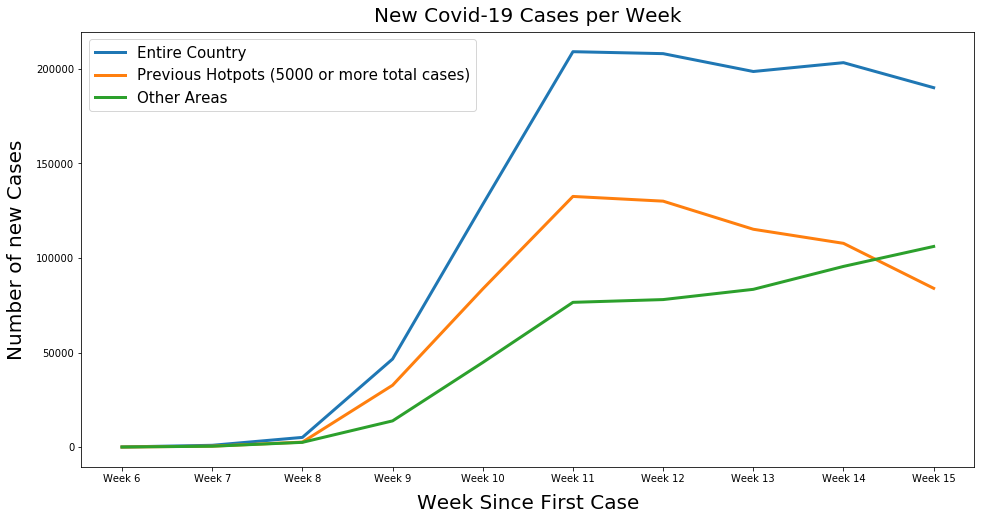

In [109]:
plt.figure(figsize=(16,8))

for series in[entire_country, hotspots, not_hotspots]:
    
    sns.lineplot(x=['Week 6', 'Week 7', 'Week 8', 'Week 9', 'Week 10', 'Week 11',
                'Week 12', 'Week 13', 'Week 14','Week 15'], 
               y=series.values, sort=False, linewidth=3)
    
plt.legend(['Entire Country', 'Previous Hotpots (5000 or more total cases)', 'Other Areas'], prop={'size': 15})
plt.title('New Covid-19 Cases per Week', fontsize=20, pad=10)
plt.xlabel('Week Since First Case', fontsize=20, labelpad=10)
plt.ylabel('Number of new Cases', fontsize=20, labelpad=10);

## Finishing Covid Features DataFrame

In [55]:
# getting case and death counts before the "target cutoff", weeks 14 and 15 are reserved to determined the target

cases_before = weekly_cases[['countyFIPS', 'Week_13']]
deaths_before = weekly_deaths[['countyFIPS', 'Week_13']]

In [56]:
covid_features = covid_features.merge(cases_before, left_on='countyFIPS', right_on='countyFIPS')

In [57]:
covid_features = covid_features.merge(deaths_before, left_on='countyFIPS', right_on='countyFIPS')

In [58]:
# renaming the columns

covid_features.columns = ['countyFIPS', 'County Name', 'State', 'population', 'County_beds',
       'Total_cases', 'Total_deaths', 'Days since case1', 'Days since death1',
       'County_hospitalizations', 'County_testing_rate', 'Deaths_wk_before',
       'Cases_we_before']

## Percentage increase in cases week before April 22

In [59]:
# adding in categorical data to the weekly cumulative cases for the future merge

cumulative_cases['County'] = df_cases['County Name']
cumulative_cases['State'] = df_cases['State']
cumulative_cases['countyFIPS'] = df_cases['countyFIPS']

cumulative_deaths['County'] = df_deaths['County Name']
cumulative_deaths['State'] = df_deaths['State']
cumulative_deaths['countyFIPS'] = df_deaths['countyFIPS']

In [61]:
# setting/applying column order

col_ord = ['countyFIPS','County', 'State', 'Week_1', 'Week_2', 'Week_3', 'Week_4', 'Week_5', 'Week_6', 'Week_7', 'Week_8',
          'Week_9', 'Week_10', 'Week_11', 'Week_12', 'Week_13', 'Week_14', 'Week_15']

In [62]:
cumulative_cases = cumulative_cases[col_ord]
cumulative_deaths = cumulative_deaths[col_ord]

In [64]:
# want the full state names

cumulative_cases.State = cumulative_cases.State.apply(lambda x: states[x])

cumulative_deaths.State = cumulative_deaths.State.apply(lambda x: states[x])

In [65]:
# making a data frame to determine the weekly percentage increases

cases_percent = cumulative_cases.copy()

In [66]:
# find the percentage increases in total cases on a week by week basic (excluding categorical columns, and first week)

cases_percent.iloc[: , 4:] = cases_percent.iloc[: , 4:].pct_change(axis=1)

In [67]:
# replacing all "infs," which indicate the first case has appeared, with the median of the column

cases_percent.Week_10.replace(np.inf, cases_percent.Week_11.median(), inplace=True)
cases_percent.Week_11.replace(np.inf, cases_percent.Week_12.median(), inplace=True)
cases_percent.Week_12.replace(np.inf, cases_percent.Week_13.median(), inplace=True)

In [68]:
# replacing NaNs with zeros

cases_percent.Week_11.replace(np.nan, 0, inplace=True)
cases_percent.Week_12.replace(np.nan, 0, inplace=True)
cases_percent.Week_13.replace(np.nan, 0, inplace=True)

In [77]:
# making a dataframe of the percentage increase in cases the three weeks leading up to the target cutoff

percent_increase = cases_percent[['countyFIPS', 'Week_11', 'Week_12', 'Week_13']]

In [78]:
# merging the percentage increase features into the covid dataframe

covid_features = covid_features.merge(percent_increase, left_on='countyFIPS', right_on='countyFIPS')

In [80]:
# renaming columns, setting/applying new column order

covid_features.columns = ['countyFIPS', 'County Name', 'State', 'population', 'County_beds',
       'Total_cases', 'Total_deaths', 'Days since case1', 'Days since death1',
       'County_hospitalizations', 'County_testing_rate','deaths_wk_before', 'cases_wk_before',
        'pcnt_inc_wk11','pcnt_inc_wk12','pcnt_inc_wk13' ]

In [81]:
col_ord = ['countyFIPS', 'County Name', 'State', 'population', 'County_beds',
       'Total_cases', 'Total_deaths', 'Days since case1', 'Days since death1',
       'County_hospitalizations', 'County_testing_rate', 'cases_wk_before',
       'deaths_wk_before', 'pcnt_inc_wk11','pcnt_inc_wk12','pcnt_inc_wk13']

In [82]:
covid_features = covid_features[col_ord]

In [83]:
# view the covid features dataframe to make sure everything looks right

covid_features.head()

,countyFIPS,County Name,State,population,County_beds,Total_cases,Total_deaths,Days since case1,Days since death1,County_hospitalizations,County_testing_rate,cases_wk_before,deaths_wk_before,pcnt_inc_wk11,pcnt_inc_wk12,pcnt_inc_wk13
0,1001,Autauga County,Alabama,55869,173,30,1,29,14,0.344198,0.017450,0.0,7.0,0.714286,0.916667,0.304348
1,1003,Baldwin County,Alabama,223234,692,123,2,39,4,0.353185,0.004367,2.0,36.0,1.210526,1.071429,0.413793
2,1005,Barbour County,Alabama,24686,76,28,0,19,0,0.727052,0.039492,0.0,17.0,1.500000,2.666667,1.545455
3,1007,Bibb County,Alabama,22394,69,32,0,23,0,0.915960,0.043534,0.0,15.0,1.666667,1.125000,0.882353
4,1009,Blount County,Alabama,57826,179,26,0,28,0,0.288209,0.016859,0.0,10.0,1.000000,0.600000,0.625000


# Producing Target

In [89]:
# function for counting specific row entries

def count_50_percent_inc(series):
    '''Counts entries in a series above 0.5'''
    return (series > 0.50).sum()

def count_75_percent_inc(series):
    '''Counts entries in a series above 0.75'''
    return (series > 0.75).sum()

def count_100_percent_inc(series):
    '''Counts entries in a series above 1'''
    return (series > 1.00).sum()

In [90]:
# produces a column containing the number of weeks cases doubled in a county over a 2 week period

cases_percent["Weeks_100_percent_inc"] = cases_percent.loc[:, 'Week_14':'Week_15'].apply(
    func=lambda row: count_100_percent_inc(row), axis=1)

cases_percent["Weeks_75_percent_inc"] = cases_percent.loc[:, 'Week_14':'Week_15'].apply(
    func=lambda row: count_75_percent_inc(row), axis=1)

cases_percent["Weeks_50_percent_inc"] = cases_percent.loc[:, 'Week_14':'Week_15'].apply(
    func=lambda row: count_50_percent_inc(row), axis=1)


In [91]:
# values counts for the newly created columns above

cases_percent.Weeks_100_percent_inc.value_counts(), cases_percent.Weeks_75_percent_inc.value_counts(), cases_percent.Weeks_50_percent_inc.value_counts()

(0    2716
 1     369
 2      60
 Name: Weeks_100_percent_inc, dtype: int64,
 0    2500
 1     527
 2     118
 Name: Weeks_75_percent_inc, dtype: int64,
 0    2236
 1     685
 2     224
 Name: Weeks_50_percent_inc, dtype: int64)

In [92]:
# total cases at the beginngin of the target cutoff

week_14 = cumulative_cases[['countyFIPS', 'Week_14']]

In [94]:
# adding the above data in to help determine the target

cases_percent = cases_percent.merge(week_14, left_on='countyFIPS', right_on='countyFIPS')

In [98]:
# setting the target

cases_percent['At_risk'] = (((cases_percent.Week_14_y > 50) & (cases_percent.Weeks_100_percent_inc) > 0) |
                           ((cases_percent.Week_14_y > 100) & (cases_percent.Weeks_75_percent_inc) > 0) |
                           ((cases_percent.Week_14_y > 150) & (cases_percent.Weeks_50_percent_inc) > 0)).astype(int)

In [99]:
# viewing percentage of "at_risk" counties based on the target above, which is around 4.5%

cases_percent.At_risk.describe()

count    3145.000000
mean        0.044833
std         0.206970
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: At_risk, dtype: float64

In [101]:
# making a dataframe which contains only the county code and the target (to make merge possible)

target = cases_percent[['countyFIPS', 'At_risk']]

# Save Tables

In [102]:
# merging the target into the covid table

covid_table = covid_features.merge(target, left_on='countyFIPS', right_on='countyFIPS')

In [104]:
# replacing NaNs in hospitalization column with zeros

covid_table.fillna(0, inplace=True)

In [105]:
covid_table = covid_table[covid_table.population != 0]

In [107]:
covid_table.to_csv('covid_table.csv', index=False, index_label='countyFIPS')